In [1]:
%%capture
## compile PyRoss for this notebook
import os
owd = os.getcwd()
os.chdir('../../')
%run setup.py install
os.chdir(owd)

In [2]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import pyross
import time 

In [3]:
M  = 2                  # the population has two age groups
N  =  5e4           # and this is the total population

# correct params

beta  = 0.02         # infection rate
gIa   = 1./7            # recovery rate of asymptomatic infectives
gIs   = 1./7            # recovery rate of asymptomatic infectives
alpha = 0.2          # fraction of asymptomatic infectives
fsa   = 0.8          # the self-isolation parameter

# set the age structure
fi = np.array([0.25, 0.75])  # fraction of population in age age group
Ni = N*fi

# set the contact structure
C = np.array([[18., 9.], [3., 12.]])

# set up initial condition
Ia0 = np.array([10, 10])  # each age group has asymptomatic infectives
Is0 = np.array([10, 10])   # and also symptomatic infectives
R0  = np.array([0, 0])  # there are no recovered individuals initially
S0  = Ni - (Ia0 + Is0 + R0)

Tf = 100
Nf = Tf+1

def contactMatrix(t):
    return C

parameters = {'alpha':alpha, 'beta':beta, 'gIa':gIa, 'gIs':gIs,'fsa':fsa}

# use pyross stochastic to generate traj and save 
# sto_model = pyross.stochastic.SIR(parameters, M, Ni)
# data = sto_model.simulate(S0, Ia0, Is0, contactMatrix, Tf, Nf)
# data_array = data['X']
# np.save('SIR_sto_traj.npy', data_array)

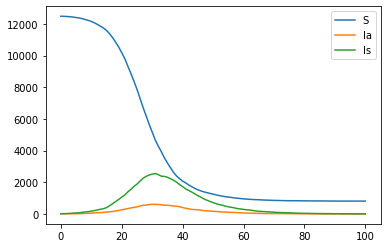

In [3]:
plt.plot(data_array[:, 0], label='S')
plt.plot(data_array[:, M], label='Ia')
plt.plot(data_array[:, 2*M], label='Is')
plt.legend()
plt.show()

In [4]:
# load the data and rescale to intensive variables 
Tf = 50 # truncate to only getting the first few datapoints 
Nf = Tf+1

x = np.load('SIR_sto_traj.npy').astype('float')
x = (x/N)[:Nf]
steps = 101 # number internal integration steps taken, must be an odd number 


# initialise the estimator 
estimator = pyross.inference.SIR(parameters, M, fi, int(N), steps)

# compute -log_p for the original (correct) parameters 
start_time = time.time() 
parameters = {'alpha':alpha, 'beta':beta, 'gIa':gIa, 'gIs':gIs,'fsa':fsa}
logp = estimator.obtain_minus_log_p(parameters, x, Tf, Nf, contactMatrix)
end_time = time.time()
print(logp) 
print(end_time - start_time)

-2116.698339191044
0.3131542205810547


In [5]:
# take a guess 
beta_g = 0.1
gIa_g = 0.14
gIs_g = 0.2
alpha_g = 0.3

# compute -log_p for the initial guess 
parameters = {'alpha':alpha_g, 'beta':beta_g, 'gIa':gIa_g, 'gIs':gIs_g,'fsa':fsa}
logp = estimator.obtain_minus_log_p(parameters, x, Tf, Nf, contactMatrix)
print(logp) 

50589.08100075516


In [7]:
# inference 
eps = 1e-4 
ftol = 1e-6
guess = np.array([alpha_g, beta_g, gIa_g, gIs_g])
bounds = np.array([(eps, 0.8), (eps, 0.2), (eps, 0.6), (eps, 0.6)]) # give some bounds
stds = np.array([0.2, 0.1, 0.05, 0.1])
start_time = time.time() 
params = estimator.inference(guess, stds, x, Tf, Nf, contactMatrix, 
                                  bounds=bounds, global_max_iter=10,
                                  eps=eps, global_ftol_factor=1e3, ftol=ftol, verbose=True)
end_time = time.time()

print(params) # best guess 
print(end_time - start_time)

Starting global minimisation...
(8_w,16)-aCMA-ES (mu_w=4.8,w_1=32%) in dimension 4 (seed=386321, Thu Apr 30 16:51:44 2020)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     16 1.906128507941868e+04 1.0e+00 1.15e+00  4e-02  1e-01 0:09.9
    2     32 -1.892600890829464e+03 1.5e+00 1.78e+00  6e-02  2e-01 0:17.3
    3     48 2.947888786227623e+03 1.6e+00 1.76e+00  5e-02  2e-01 0:23.6
    4     64 9.349987883169077e+02 1.7e+00 1.51e+00  4e-02  2e-01 0:29.1
    5     80 -1.463624532318144e+03 1.9e+00 1.36e+00  3e-02  1e-01 0:35.3
    6     96 -6.291188950760958e+02 1.9e+00 1.46e+00  3e-02  1e-01 0:40.4
    8    128 -1.484481106414612e+03 2.8e+00 8.68e-01  9e-03  8e-02 0:51.8
   10    160 -1.602830935770506e+03 4.2e+00 8.67e-01  8e-03  8e-02 1:03.1
Optimal value (global minimisation):  -1892.6008908294643
Starting local minimisation...
Optimal value (local minimisation):  -2122.610776713537
[0.20355107 0.02003734 0.14634491 0.1425748 ]
159.26013207435608


In [8]:
# compute log_p for best estimate 
start_time = time.time() 
parameters = {'alpha': params[0], 'beta': params[1], 'gIa': params[2], 'gIs': params[3],'fsa':fsa}
logp = estimator.obtain_minus_log_p(parameters, x, Tf, Nf, contactMatrix)
end_time = time.time()
print(logp) 
print(end_time - start_time)

-2116.1062976695293
0.31566500663757324


In [9]:
hess = estimator.hessian(params, guess, stds, x, Tf, Nf, contactMatrix)
cov = np.linalg.inv(hess)

In [14]:
np.linalg.

[[ 4.65430433e-05  4.15620829e-10  3.36940243e-05 -8.67252688e-06]
 [ 4.15620829e-10  1.29621351e-08  5.78612875e-10  2.09193539e-10]
 [ 3.36940243e-05  5.78612875e-10  3.06395131e-05 -6.98668171e-06]
 [-8.67252688e-06  2.09193539e-10 -6.98668171e-06  2.60758109e-06]]
